<a href="https://colab.research.google.com/github/neohack22/ebw3nt/blob/main/modelisation/Impl%C3%A9mentationCBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal is to set up a simple classifier for text and sentiment analysis. The task is the binary classification of movie reviews. The dataset is a part of the *imdb* dataset. You can find the original dataset on the [imdb website](https://www.imdb.com/interfaces/) or a version on the [kaggle website](https://www.kaggle.com/utathya/imdb-review-dataset). For this lab session, we will use a preprocessed version.


The roadmap is:
- Load, clean and setup the data (in practice this a very important step, for this lab we skip it).
- Make it suitable for pytorch models
- Define your own model
- Experiments


# The data

Datasets are available in the cloud repository. There are 2 files, one for positive reviews (imdb.pos) and one for the negative ones (imdb.neg). There are  300000 examples of each class.

Here two functions to load and clean the data.

In [ ]:
import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import random
import math
import pickle
import gzip

th.manual_seed(1) # set the seed

# Data loading


Load the data :

In [ ]:
# find the file imdb.pck.gz, and set the next variable accordingly
filename = 'imdb.pck.gz'

# You can download the file with the following line:
! wget "https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA" -O imdb.pck.gz

--2022-04-06 11:30:46--  https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA
Resolving drive.google.com (drive.google.com)... 172.217.18.206, 2a00:1450:4007:812::200e
Connecting to drive.google.com (drive.google.com)|172.217.18.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n2hk1hevtcvg0o0qrmu5u6kngpg8htco/1649237400000/16692574002775380562/*/1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA?e=download [following]
--2022-04-06 11:30:50--  https://doc-0k-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n2hk1hevtcvg0o0qrmu5u6kngpg8htco/1649237400000/16692574002775380562/*/1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA?e=download
Resolving doc-0k-0o-docs.googleusercontent.com (doc-0k-0o-docs.googleusercontent.com)... 216.58.213.129, 2a00:1450:4007:811::2001
Connecting to doc-0k-0o-docs.googleusercontent.com (doc-0k-0o-docs.googleus

Open the data with python and you will get 3 objects :
- *texts*  : a list of tensors, each tensor represent a word sequence to classify.
- *labels* : the class, positive or negative, of the corresponding text
- *lexicon*: a dictionnary to map integers to real words


In [ ]:
fp = gzip.open(filename,'rb')
texts , labels, lexicon  = pickle.load(fp)

print(type(texts), type(labels), type(lexicon))
print(texts[0])
print("nb examples : ", len(texts))
VOCAB_SIZE = len(lexicon)
print("Vocab size: ", VOCAB_SIZE)

<class 'list'> <class 'torch.Tensor'> <class 'dict'>
tensor([ 36,  25, 381,  10,  58,  21,  83])
nb examples :  30000
Vocab size:  5002


Note that a reduced number of words are selected to build the vocabulary. The less frequent words are discarded are replaced by a specific form (*unk* for unknown).


In [ ]:
for i in range(10):
    print("word of index", i , " : ", lexicon[i])

word of index 0  :  <pad>
word of index 1  :  <unk>
word of index 2  :  !
word of index 3  :  the
word of index 4  :  a
word of index 5  :  of
word of index 6  :  movie
word of index 7  :  and
word of index 8  :  this
word of index 9  :  to


To read the text you can use for example the following code:

In [ ]:
def idx2wordlist(idx_array,lexicon):
    l = []
    for i in idx_array:
        l.append(lexicon[i.item()])
    return l
print(texts[0].shape)
print("Some positive reviews")
print("------------")
for i in range(5):
    print(
        idx2wordlist(
            texts[
                i+50],lexicon)) # les critiques positives sont regroupées dans une certaine partie de la liste texts
print("Some negative reviews")
print("------------")
for i in range(5):
    print(
        idx2wordlist(
            texts[
                -i-2000],lexicon)) # les critiques négatives sont stockées à la fin de la liste

print("-----------\nA random sentence: ")
print(idx2wordlist(texts[104],lexicon))

torch.Size([7])
Some positive reviews
------------
['strong', 'drama']
['please', 'remake', 'this', 'movie']
['very', 'funny', '!']
['great', 'series']
['fun', 'movie']
Some negative reviews
------------
['absolute', 'waste', 'of', 'time']
['the', 'worst', 'movie', 'ever', 'made']
['slow', 'motion', 'picture', 'that', 'did', "n't", 'get', 'to', 'the', 'point']
['there', 'are', 'good', 'bad', 'movies', 'and', 'there', 'are', 'bad', 'bad', 'movies', 'this', 'one', 'is', 'a', 'real', 'stinker']
['<unk>', 'so', 'bad', 'its', 'funny']
-----------
A random sentence: 
['you', 'definitely', 'need', 'to', 'see', 'this', 'movie']


# Interface données/modèle
En pratique, nous partons de textes bruts et nous devons les convertir en indices de mots. À cette étape, nous pouvons effectuer un prétraitement du texte, une tokenisation et un nettoyage des données. Dans le cas présent, c'est déjà fait. Mais dans la vie réelle, c'est une étape très importante.

L'objectif est d'implémenter un classificateur CBOW (Continuous Bag of Words, ou un sac d'embeddings de mots). Cela signifie que la première couche du modèle gère les embeddings de mots.

Le module Embedding de PyTorch est conçu à cet effet. Ce module attend en entrée un tableau ou une liste d'indices de mots. Pour cette session, l'objectif est de développer rapidement un modèle. L'interface de données est donc plutôt simple. Nous terminons cette section en créant des labels.


# Un premier modèle

Le premier modèle est un CBOW (Continuous Bag of Words). Un texte est représenté comme un ensemble de mots (un sac de caractéristiques binaires) :

- Chaque mot est associé à son embedding.
- Le texte est représenté comme la somme des embeddings de mots impliqués.
- Cette somme d'embeddings est ensuite alimentée à une couche linéaire avec une unité de sortie,
- suivie par l'activation sigmoïde. La sortie du modèle est similaire à une régression logistique.

Maintenant, nous voulons coder cela en PyTorch. Une façon est d'abord d'essayer de construire un tel modèle **étape par étape**, puis de créer une classe pour tout encapsuler dans un **modèle**.

## Construction du modèle, étape par étape

La couche d'entrée du modèle est une couche d'Embedding. Celle-ci est déjà implémentée dans PyTorch.

In [ ]:
# build an Embedding layer
# it is important to understand the parameters given to the constructor !
D = 4
embLayer = th.nn.Embedding(num_embeddings=len(lexicon), embedding_dim=D)
# The dim of 4 is a toy example.
# run forward on some input
inp = texts[104]
embs = embLayer(inp) # embLayer.forward(inp)
# Look at the dimension of i/o
print("The input: ",inp)
print("length: ",len(inp))
print("Embs shape : ",embs.shape)
print(embs)

The input:  tensor([ 21, 316, 320,   9,  59,   8,   6])
length:  7
Embs shape :  torch.Size([7, 4])
tensor([[ 0.6971, -0.9576, -1.0220,  1.3295],
        [ 1.0256,  1.7889, -1.2001,  0.8268],
        [-1.1081,  0.4350, -0.5725, -1.6943],
        [-0.9530, -1.2833, -0.6837,  1.3832],
        [ 0.2081, -0.4403,  1.3717,  0.9725],
        [-0.5415, -1.4216, -0.0367, -1.9919],
        [-1.3417,  0.0124, -1.3485, -0.5739]], grad_fn=<EmbeddingBackward>)


1.  `D = 4`: `D` représente la dimension de l'embedding, c'est-à-dire la taille du vecteur que chaque mot sera transformé. Ici, 4 est choisi comme un exemple simple.

2.  `embLayer = th.nn.Embedding(num_embeddings=len(lexicon), embedding_dim=D)`: C'est la création de la couche d'embedding.
    *   `num_embeddings=len(lexicon)`: C'est le nombre total de mots uniques dans votre vocabulaire. `len(lexicon)` donne la taille du vocabulaire que vous avez chargé précédemment (5002 dans cet exemple). Chaque mot de ce vocabulaire aura un vecteur d'embedding unique.
    *   `embedding_dim=D`: C'est la dimension de chaque vecteur d'embedding. Chaque mot sera représenté par un vecteur de 4 nombres flottants.

3.  `inp = texts[104]`: Cette ligne sélectionne un exemple d'entrée, qui est le 105ème texte (index 104) de votre ensemble de données `texts`. `inp` est un tenseur d'indices de mots, comme `tensor([ 21, 316, 320, 9, 59, 8, 6])`.

4.  `embs = embLayer(inp)`: Cette ligne exécute la propagation avant (`forward pass`) de la couche d'embedding. Elle prend le tenseur d'indices de mots (`inp`) et pour chaque index de mot, elle lui attribue le vecteur d'embedding correspondant de la couche `embLayer`.

5.  Si l'entrée a `N` mots (ici, 7 mots), la sortie `embs` aura la forme `[N, D]`, c'est-à-dire `[7, 4]`. Chaque ligne de ce tenseur de sortie est le vecteur d'embedding de dimension `D` (4) pour le mot correspondant dans l'entrée.

Maintenant, nous voulons compresser le tenseur résultant le long de la dimension temporelle.
Dans le traitement du langage naturel (NLP) et les architectures de réseaux de neurones qui traitent des séquences (comme les RNN, LSTM, Transformers), on parle souvent de la "dimension de la séquence" ou de la "longueur de la séquence" pour désigner cette dimension qui représente la succession des éléments (mots, caractères, tokens) dans le temps ou l'ordre.

Le terme "temporelle" est très pertinent car il évoque l'idée d'une série de points de données qui se suivent, comme une série temporelle. Quand on traite un texte, on le considère comme une séquence d'événements (les mots) qui arrivent dans un certain ordre, d'où l'analogie avec le temps.

Cette dimension dépend des textes d'entrée, alors que nous voulons construire une représentation de taille fixe de la phrase. La somme est une première idée.
En additionnant les vecteurs de chaque mot, vous combinez leurs informations sémantiques. Le vecteur résultant est une sorte de "moyenne" ou de "résumé" de tous les mots présents dans la phrase. Il perd l'information sur l'ordre exact des mots, mais conserve l'information sur les mots qui étaient présents et leurs caractéristiques globales.

In [ ]:
## compute the sum of out to create a vector of size "embedding_dim".
## Of course it will be a tensor with one dimension set to "embedding_dim".
sumOfEmbs = embs.sum(dim=1)
print(sumOfEmbs.shape) # check the shape
sumOfEmbs = embs.sum(dim=0)
print(sumOfEmbs.shape) # check the shape

torch.Size([7])
torch.Size([4])


La couche finale est une transformation linéaire : en entrée, nous avons un vecteur de taille embedding_dim et 1 en sortie. Codons cette transformation et vérifions la forme du résultat final.

In [ ]:
# Compute out, after you created the Linear layer
th.manual_seed(12) # set the seed
W  = th.nn.Linear(in_features=D, out_features=1) # création de la couche linéaire.

out_activation = th.nn.Sigmoid()
out= out_activation( # Le résultat de la couche linéaire est passé à la fonction Sigmoïde
    W(sumOfEmbs)) # notre représentation fixe de la phrase est passée à la couche linéaire W
print(out.shape,out)

W  = th.nn.Linear(in_features=D, out_features=1)
out_activation = th.nn.Sigmoid()
out= out_activation(W(sumOfEmbs))
print(out.shape,out)

torch.Size([1]) tensor([0.6601], grad_fn=<SigmoidBackward>)
torch.Size([1]) tensor([0.8424], grad_fn=<SigmoidBackward>)


La fonction Sigmoïde prend n'importe quelle valeur réelle et la compresse dans l'intervalle [0, 1]. Dans un contexte de classification binaire, cela peut être interprété comme la probabilité que l'entrée appartienne à la classe positive.

## Encapsuler le tout dans un joli module/modèle

Pour écrire votre propre module, héritez de la classe *Module*.

In [ ]:
class CBOW_classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier, self).__init__()
        self.emb = nn.Embedding( # crée la couche d'embedding
            vocab_size, embedding_dim) # Cette couche prendra des indices de mots en entrée et retournera leurs vecteurs d'embedding correspondants
        self.lin = nn.Linear( # crée la couche linéaire
            embedding_dim, 1)

    def forward( # comment une entrée (inp) est transformée pour produire la sortie du modèle
        self, inp):
        return th.sigmoid(
            self.lin(
                self.emb( # convertit chaque indice de mot en son vecteur d'embedding
                    inp).sum(
                        dim=0)))


Cette classe hérite de *Module*. Ces deux méthodes sont obligatoires. Le constructeur construit un modèle avec ses paramètres initialisés. Le *forward* est pour l'inférence.

Le tenseur d'embeddings résultant de l'étape précédente (qui a la forme [nombre_de_mots, embedding_dim]) est ensuite sommé le long de la dimension 0 (la dimension des mots). Cela produit un seul vecteur de taille embedding_dim, qui représente la phrase entière (le principe du Bag of Words).

Dans PyTorch, un modèle prend des *Tensors (variables)* en entrée et renvoie des *Tensors (variables)*. La sortie est comparée à la vérité terrain par la fonction de perte.

Prenons un exemple d'entraînement et vérifions si le passage avant (forward pass) est correct. Le résultat devrait être un *FloatTensor* avec une seule valeur : le score entre 0 et 1 attribué par le modèle à l'exemple.

In [ ]:
classifier = CBOW_classifier(
    vocab_size=len(
        lexicon),embedding_dim=10) # hyperparamètre important que vous pourrez ajuster
print(classifier(texts[0]))
print(labels[0]) # vrai label

tensor([0.6236], grad_fn=<SigmoidBackward>)
tensor(0.)


Cette valeur est la prédiction du modèle pour le texte texts[0], représentant la probabilité que ce texte soit une critique positive. Une valeur proche de 1 indique une forte probabilité d'être positif, et une valeur proche de 0 indique une forte probabilité d'être négatif.

In [ ]:
print(classifier.forward(texts[0]))

tensor([0.6236], grad_fn=<SigmoidBackward>)


classifier(texts[0]) est une syntaxe raccourcie et préférée pour classifier.forward(texts[0]) dans PyTorch

## Fonction objectif
La fonction de perte (ou fonction objectif) est adaptée au modèle et à la tâche.

- Lisez la documentation du module **nn** : http://pytorch.org/docs/master/nn.html.
- Dans notre cas, deux fonctions de perte peuvent être utilisées : *BCELoss* et *BCEWithLogitsLoss*. Comparez-les et faites votre choix.
- Compte tenu de ce choix, vous pourriez vouloir modifier la classe *CBOW_Classifier*.

In [ ]:
## define de training function
loss_fn = nn.BCELoss()



## Entraînement

Écrivons le code pour entraîner le modèle, surveiller le processus d'entraînement et évaluer le modèle à l'aide des données de test. Commençons avec un optimiseur SGD avec un taux d'apprentissage de 0,1.

### Ordre aléatoire
Dans de nombreux cas, il peut être important d'itérer sur les données dans un ordre aléatoire et non dans l'ordre dans lequel nous avons construit le corpus. Cet ordre initial peut introduire un biais dans le processus d'évaluation. Une méthode simple pour mélanger les données est de mélanger les indices que nous utilisons. Supposons que nous ayons 10 échantillons d'entraînement, nous pouvons faire quelque chose comme :

In [ ]:
ids = list(range(10))
import random
random.shuffle(ids)
for i in ids:
    print(i)

4
0
2
3
8
7
9
6
1
5


C'est une technique courante en apprentissage automatique pour s'assurer que les données sont traitées dans un ordre non séquentiel, ce qui aide à éviter les biais et à améliorer la généralisation du modèle pendant l'entraînement.

##### Maintenant, nous avons tout pour exécuter la boucle d'entraînement et tester ce modèle.

In [ ]:
total = len(texts)
randomidx = list(range(total))
preds = th.zeros(
    total) # sera utilisé pour stocker les prédictions du modèle pour chaque exemple à la fin de chaque époque.
optimizer = th.optim.SGD(
    classifier.parameters(

    ),lr=1e-2) # détermine la taille des pas effectués lors de la mise à jour des poids
Nepochs = 10
losses = th.zeros(
    Nepochs) # Initialise un tenseur pour stocker la perte moyenne de chaque époque
for epoch in range(Nepochs):
    total_loss = th.Tensor(
        [0]) # Réinitialise la perte totale accumulée pour l'époque courante à 0
    correct=0 # Réinitialise le compteur de prédictions correctes pour l'époque courante à 0
    random.shuffle(
        randomidx) # éviter l'apprentissage de motifs liés à l'ordre des données plutôt qu'aux données elles-mêmes
    for i in randomidx:
        classifier.zero_grad(

        )
        x = texts[
            i] # Récupère le texte (séquence d'indices de mots) pour l'exemple courant
        probs = classifier(
            x)[0] # extraire la seule valeur scalaire de probabilité du tenseur de sortie
        loss = loss_fn(
            probs, labels[
                i]) # perte (erreur) entre la probabilité prédite et le vrai label
        pred= probs>0.5
        preds[i] = pred
        if pred.item(

        ) == labels[ # Vérifie si la prédiction correspond au vrai label
            i].item() :
            correct +=1
        loss.backward(

        ) # calcule les gradients de la fonction de perte par rapport à tous les paramètres du modèle
        optimizer.step(

        ) # Met à jour les poids du modèle
        total_loss += loss.data
    losses[epoch] = total_loss/total # perte moyenne pour l'époque
    print(epoch, losses[epoch], 100.0*correct/total, preds.sum())


0 tensor(0.7279) 54.54333333333334 tensor(15049.)
1 tensor(0.6946) 58.906666666666666 tensor(15068.)
2 tensor(0.6643) 62.86333333333334 tensor(14997.)
3 tensor(0.6356) 65.49333333333334 tensor(15064.)
4 tensor(0.6110) 67.36 tensor(14950.)
5 tensor(0.5916) 68.86666666666666 tensor(14988.)
6 tensor(0.5753) 69.91333333333333 tensor(14934.)
7 tensor(0.5615) 71.37 tensor(14945.)
8 tensor(0.5477) 72.33666666666667 tensor(14995.)
9 tensor(0.5371) 72.68 tensor(14916.)


*   epoch : Le numéro de l'époque.
*   losses[epoch] : La perte moyenne de l'époque.
*   100.0*correct/total : L'exactitude (accuracy) du modèle sur l'ensemble du jeu de données pour cette époque (en pourcentage).
*   preds.sum() : Le nombre total de prédictions positives faites par le modèle sur l'ensemble du jeu de données. Cela peut donner une idée du biais du modèle (s'il prédit trop souvent positif ou négatif).

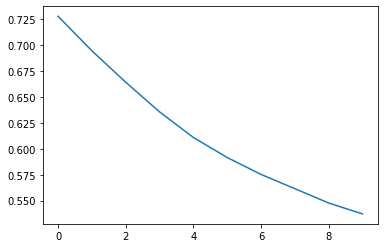

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

# First Experiments

- Make experiments  with  2000 to start then all the data for training (equally distributed between positive and negative examples).
- You should create a development and test sets.
- Test different parametrization of the model (here the embedding size) and the hyper-parameter (the learning rate) for each setups.
- Compare these different setups (loss function on the train and also the classification accuracy).



# A deeper model

We can add a hidden layer to the previous classifier.
- Do the same as before with the different setups
- Find the good choice of hyper-parameters.  

